In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK, show_pathways_in_ranked_genes
from dokdonia.utils import take_average_values, save_to_pickle_file, read_from_pickle_file

%matplotlib inline


root_dir = Path(os.getcwd()).parent
results_dir = root_dir / "results"
data_dir = root_dir / "data"

## Load counts

In [2]:
min_count = 10

counts = pd.read_csv(data_dir / 'counts' / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
# Remove columns: L_18_R2, D_18_R3 for fair comarison with TC data
counts = counts.drop(columns=["L_18_R2", "D_18_R3"])

## Load KEGG pathways and genome annotations

In [3]:
gbk = GenomeGBK(data_dir / 'genome' / 'DokdoniaMED134.gbk')

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
# gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

There are a total of 781 genes


## Get DeSeq2 normalized counts

In [4]:
# Deseq2 normalization
colfactor = pd.DataFrame(
    {'Sample': counts.columns, 'Temperature': counts.columns.str.extract(r'_(\d+)_', expand=False)}
    ).iloc[1:, :].set_index('Sample', inplace=False)
colfactor.head()

deseq2_counts = DE.deseq2Normalize(counts, colfactor,
                gene_column="index",
                design_formula="~ Temperature")
deseq2_counts.to_csv(data_dir / "processed" / "DokdoniaMED134_DS2.tsv", sep="\t", index=False)
deseq2_counts.head()

INFO:DESeq2:Normalizing counts


,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R4,D_25_R1,D_25_R2,D_25_R3,D_34_R1,...,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4,index
MED134_07389,17261.036245,14131.481038,17596.475182,25980.085561,23429.275742,26800.341843,37314.866105,33661.999186,29391.827472,29415.514306,...,28742.897221,26228.601580,37473.126338,40490.705262,36594.018059,29716.502498,32526.509526,30108.304540,34418.205106,MED134_07389
MED134_07384,2071.643678,1923.197358,2060.956115,3529.165228,3355.456729,3509.867033,5232.675318,4689.114719,4049.751496,4316.805280,...,3604.715822,3776.020942,5148.232218,5372.750997,5256.806808,4042.918851,4987.685078,4729.255314,4652.652895,MED134_07384
MED134_07379,4523.820491,4104.882335,4346.333354,6123.441013,6047.474237,6016.914913,9195.647167,7874.468097,7891.975462,7681.905582,...,6435.191982,6423.410883,8634.855625,8750.130597,8430.858456,7626.551332,7996.463321,7954.199077,8228.732614,MED134_07379
MED134_07374,2643.773917,2626.926809,1864.421640,2976.884804,2886.381478,3106.351707,3192.971548,3448.459616,3243.358811,2777.814002,...,3070.550474,3440.693581,3406.820582,3488.017898,3447.864262,3115.355186,3250.236371,2894.944385,3167.826984,MED134_07374
MED134_07369,2776.827460,2485.933563,2803.272139,3201.699416,2914.694340,3463.307572,3235.248792,3594.052000,2937.255706,3249.650859,...,4148.484143,3924.765374,3519.874584,4035.386316,3716.734411,4134.326579,3740.501354,2994.275301,3064.871119,MED134_07369


## Compute Transcript / cell values

Samples with suspiscious experimental data:  D18_R2, L10_R1

In [5]:
sample_meta = pd.read_excel(data_dir / "normalization" / "Abundances_9Jun23.xlsx")
sample_meta["Sample"] = sample_meta['Light/Dark'] + '_' + sample_meta['Temperature'].astype(str) + '_' + sample_meta['Replicate']
sample_meta.head()

,Temperature,Light/Dark,Replicate,Total biovolume (um3),Total abundance (cells),Avg_Standard_ratio,Sample
0,10,L,R1,2.294207e+08,7.609607e+08,7128.171978,L_10_R1
1,10,L,R2,1.803365e+08,5.434251e+08,22976.436275,L_10_R2
2,10,L,R3,1.960539e+08,6.095364e+08,20778.875834,L_10_R3
3,10,D,R1,1.841892e+08,5.789344e+08,12210.079577,D_10_R1
4,10,D,R2,1.900776e+08,5.737051e+08,18207.999370,D_10_R2


In [6]:
TC = DE.get_transcript_cell(counts, sample_meta, ["D_25_R1", "D_18_R2", "L_10_R1"]).set_index("index")
TC.to_csv(data_dir / "processed" / "DokdoniaMED134_TC.tsv", sep="\t")
TC.head()

,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_25_R2,D_25_R3,D_34_R1,D_34_R2,D_34_R3,D_34_R4,...,L_10_R3,L_18_R1,L_18_R3,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
index,,,,,,,,,,,,,,,,,,,,,
MED134_07389,0.273608,0.362633,0.314843,1.400648,1.168274,1.291959,1.606026,1.354968,1.020768,1.118174,...,0.408360,0.986825,0.569171,0.853985,1.864628,0.917180,0.846804,0.944030,1.231293,1.381038
MED134_07384,0.032838,0.049352,0.036875,0.190266,0.162741,0.178013,0.235689,0.193355,0.163183,0.178798,...,0.054271,0.133927,0.071381,0.117324,0.247419,0.131755,0.115207,0.144760,0.193405,0.186689
MED134_07379,0.071708,0.105337,0.077766,0.330129,0.273291,0.346903,0.419416,0.335165,0.274610,0.303465,...,0.111541,0.220965,0.127431,0.196782,0.402950,0.211308,0.217327,0.232085,0.325291,0.330180
MED134_07374,0.041907,0.067411,0.033359,0.160491,0.119682,0.142566,0.151663,0.133189,0.077265,0.113403,...,0.054748,0.110957,0.060803,0.077639,0.160626,0.086416,0.088775,0.094333,0.118390,0.127110
MED134_07369,0.044016,0.063792,0.050157,0.172611,0.124735,0.129111,0.177424,0.134795,0.077241,0.123901,...,0.066100,0.134110,0.082149,0.080215,0.185833,0.093155,0.117812,0.108562,0.122452,0.122979


## Compare median values between counts, DeSeq2-normalized counts, and transcript / cell values

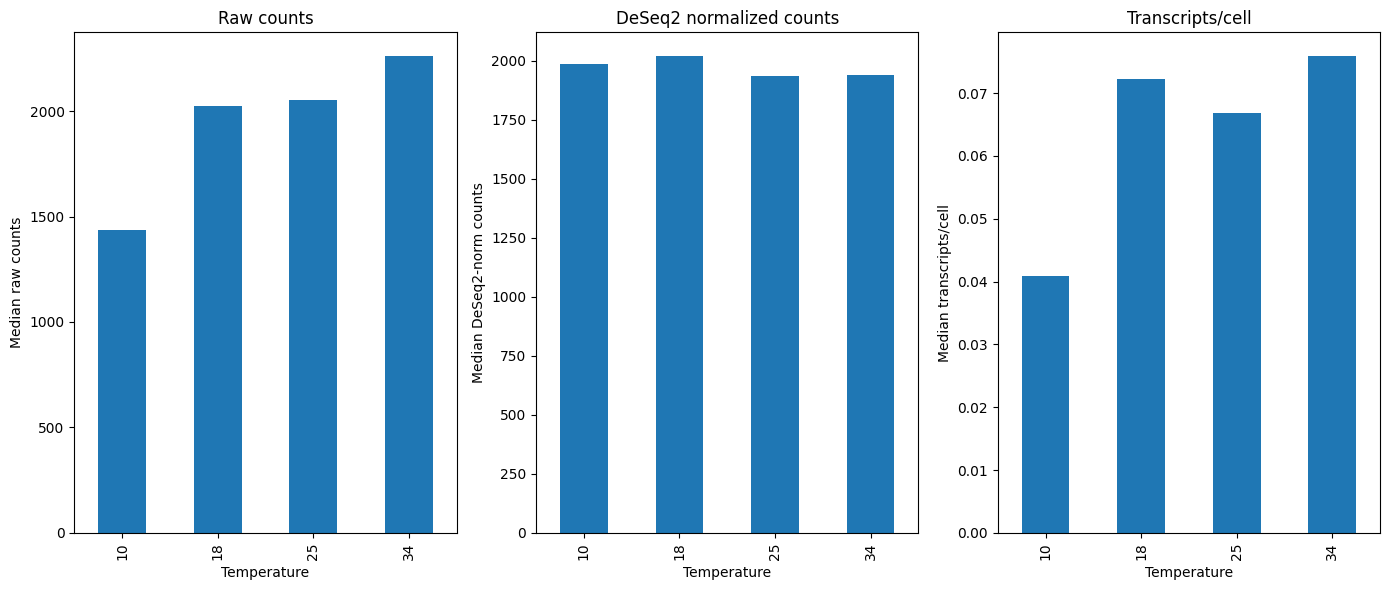

In [7]:
# Take median values across replicates
counts_avg = take_average_values(counts.set_index("index")).median()
TC_avg = take_average_values(TC, method='median')
DS2_avg = take_average_values(deseq2_counts.set_index("index")).median()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

ax0 = counts_avg.plot(kind='bar', ax=axes[0], title='Raw counts')
ax0.set_xlabel('Temperature')
ax0.set_ylabel('Median raw counts')

ax1 = DS2_avg.plot(kind='bar', ax=axes[1], title='DeSeq2 normalized counts')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Median DeSeq2-norm counts')

ax2 = TC_avg.median().plot(kind='bar', ax=axes[2], title='Transcripts/cell')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Median transcripts/cell')

plt.tight_layout()
plt.show()

## Remove Light/Dark DE genes from datasets

In [8]:
DE_all_T = read_from_pickle_file(results_dir / "deseq_results" / "DE_all_T.pkl")
DE_genes_across_T = read_from_pickle_file(results_dir / "deseq_results" / "DE_genes_across_T.pkl")

# Remove light-dark DE genes from counts
counts_noDE = counts.loc[(
    (~counts["index"].isin(DE_all_T))
    )]

# Remove light-dark DE genes from Deseq2 dataset
deseq2_counts_noDE = deseq2_counts.loc[(
    (~deseq2_counts["index"].isin(DE_all_T))
    )]

# Remove light-dark DE genes from TC dataset
TCnoDE = TC.loc[(
    (~TC.index.isin(DE_all_T))
    )]

# Find clusters based on expression pattern across temperatures: DeSeq2-normalized counts

In [9]:
# Using Deseq2 data
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2_ZSCORES'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_DS2Z = CA.getGeneClusters(deseq2_counts_noDE.set_index("index"),path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization_only_zscores.txt',
                              replicates_file='clust_replicates_merged_L_D_volume.txt',
                              scaling_factor=1)

# Plot clusters
plot_cluster_data_DS2Z = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

Traceback (most recent call last):
  File "/home/robaina/miniconda3/envs/dokdonia/bin/clust", line 8, in <module>
    sys.exit(main())
  File "/home/robaina/miniconda3/envs/dokdonia/lib/python3.9/site-packages/clust/__main__.py", line 102, in main
    clustpipeline.clustpipeline(args.datapath, args.m, args.r, args.n, args.o, args.K, args.t,
  File "/home/robaina/miniconda3/envs/dokdonia/lib/python3.9/site-packages/clust/clustpipeline.py", line 62, in clustpipeline
    shutil.copy(replicatesfile, os.path.join(in2out_path, 'Replicates.txt'))
  File "/home/robaina/miniconda3/envs/dokdonia/lib/python3.9/shutil.py", line 427, in copy
    copyfile(src, dst, follow_symlinks=follow_symlinks)
  File "/home/robaina/miniconda3/envs/dokdonia/lib/python3.9/shutil.py", line 264, in copyfile
    with open(src, 'rb') as fsrc:
FileNotFoundError: [Errno 2] No such file or directory: '/home/robaina/Documents/Aquifex/Dokdonia/data/clust_input/clust_replicates_merged_L_D_volume.txt'


## Plot original DeSeq2-based clusters

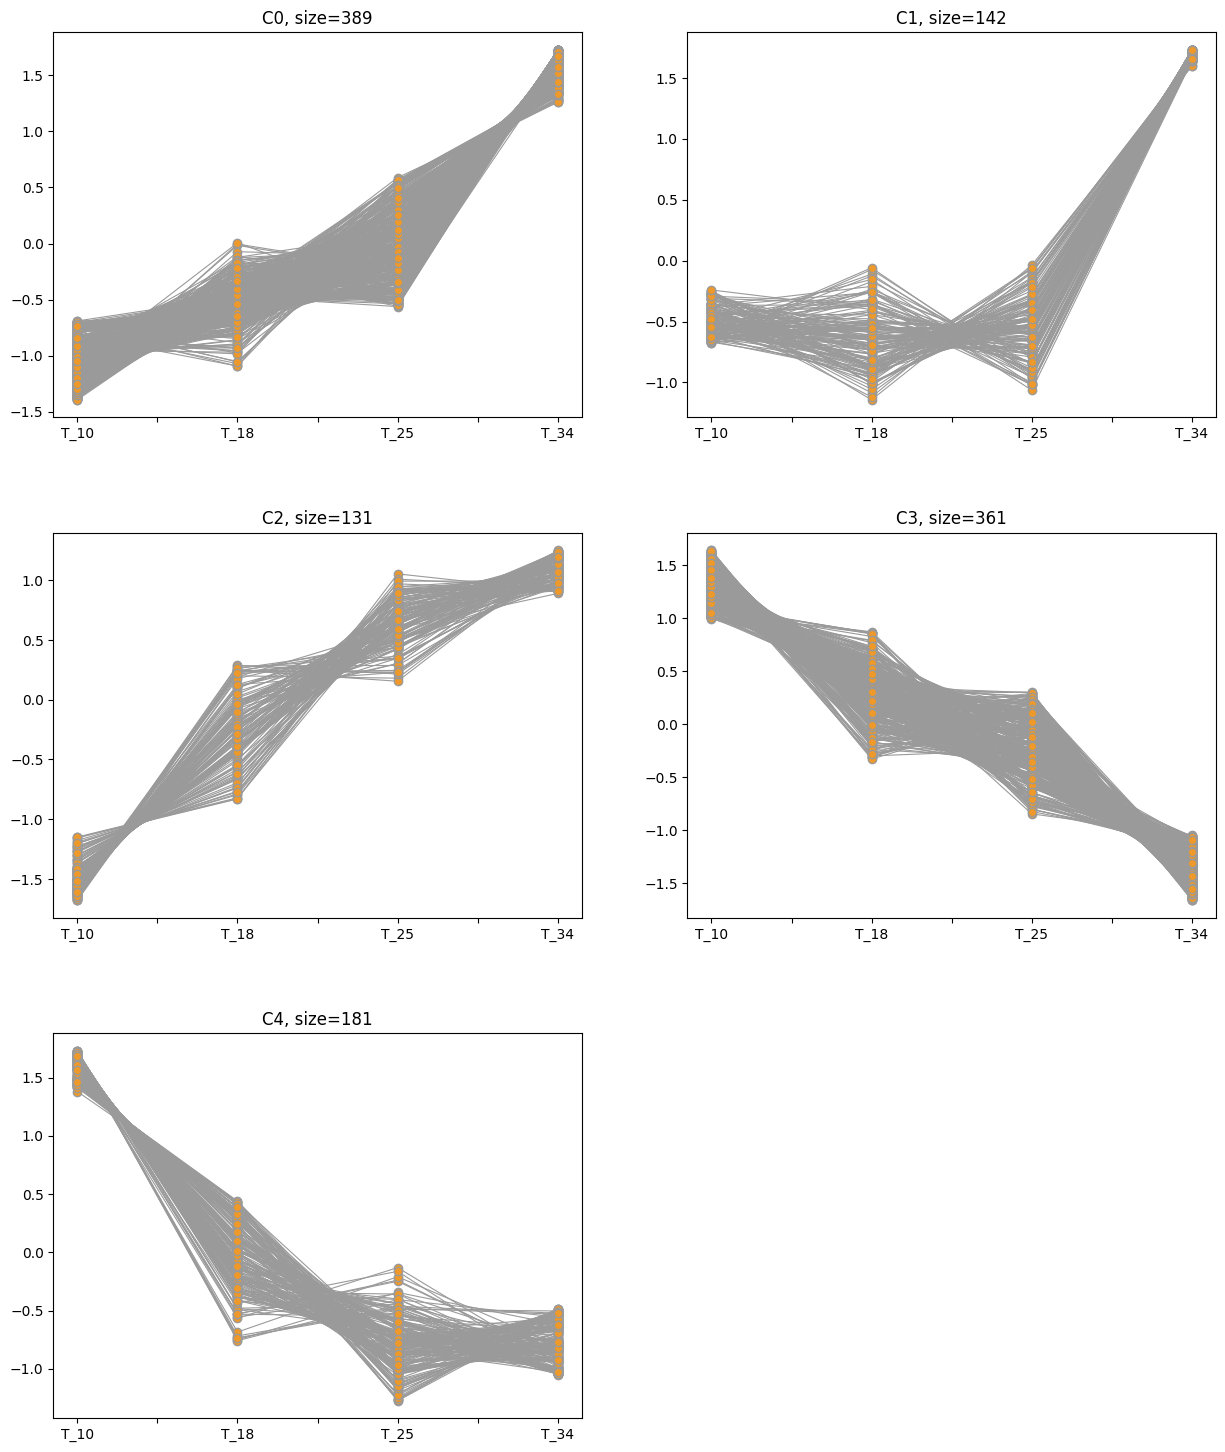

In [10]:
VI.plotClusters(plot_cluster_data_DS2Z, clusters_DS2Z)

In [11]:
# Print total number of genes contained in the sum of all clusters
total_genes_in_clusters = [g for cluster in clusters_DS2Z.values() for g in cluster]
print(f'Total number of genes in all clusters: {len(total_genes_in_clusters)}')
# Print fraction of total genes in cluisters versus total number of genes
print(f'Fraction of total genes in clusters: {len(total_genes_in_clusters) / len(plot_cluster_data_DS2Z)}')

Total number of genes in all clusters: 1204
Fraction of total genes in clusters: 0.42053789731051344


In [12]:
# Rename clusters to group by pattern
cluster_map = {
    "C0": "C0",
    "C1": "C2",
    "C2": "C3",
    "C3": "C1",
    "C4": "C4"
}

clusters_DS2Z = {
    cluster_map[cluster_id]: cluster
    for cluster_id, cluster in clusters_DS2Z.items()
    if cluster_id != "C5"
}

clusters_DS2Z = dict(sorted(clusters_DS2Z.items(), key=lambda x: x[0]))

# Save figure data
save_to_pickle_file(clusters_DS2Z, results_dir / "clusters" / "clusters_DS2Z.pkl")
save_to_pickle_file(plot_cluster_data_DS2Z, results_dir / "clusters" / "plot_cluster_data_DS2Z.pkl")


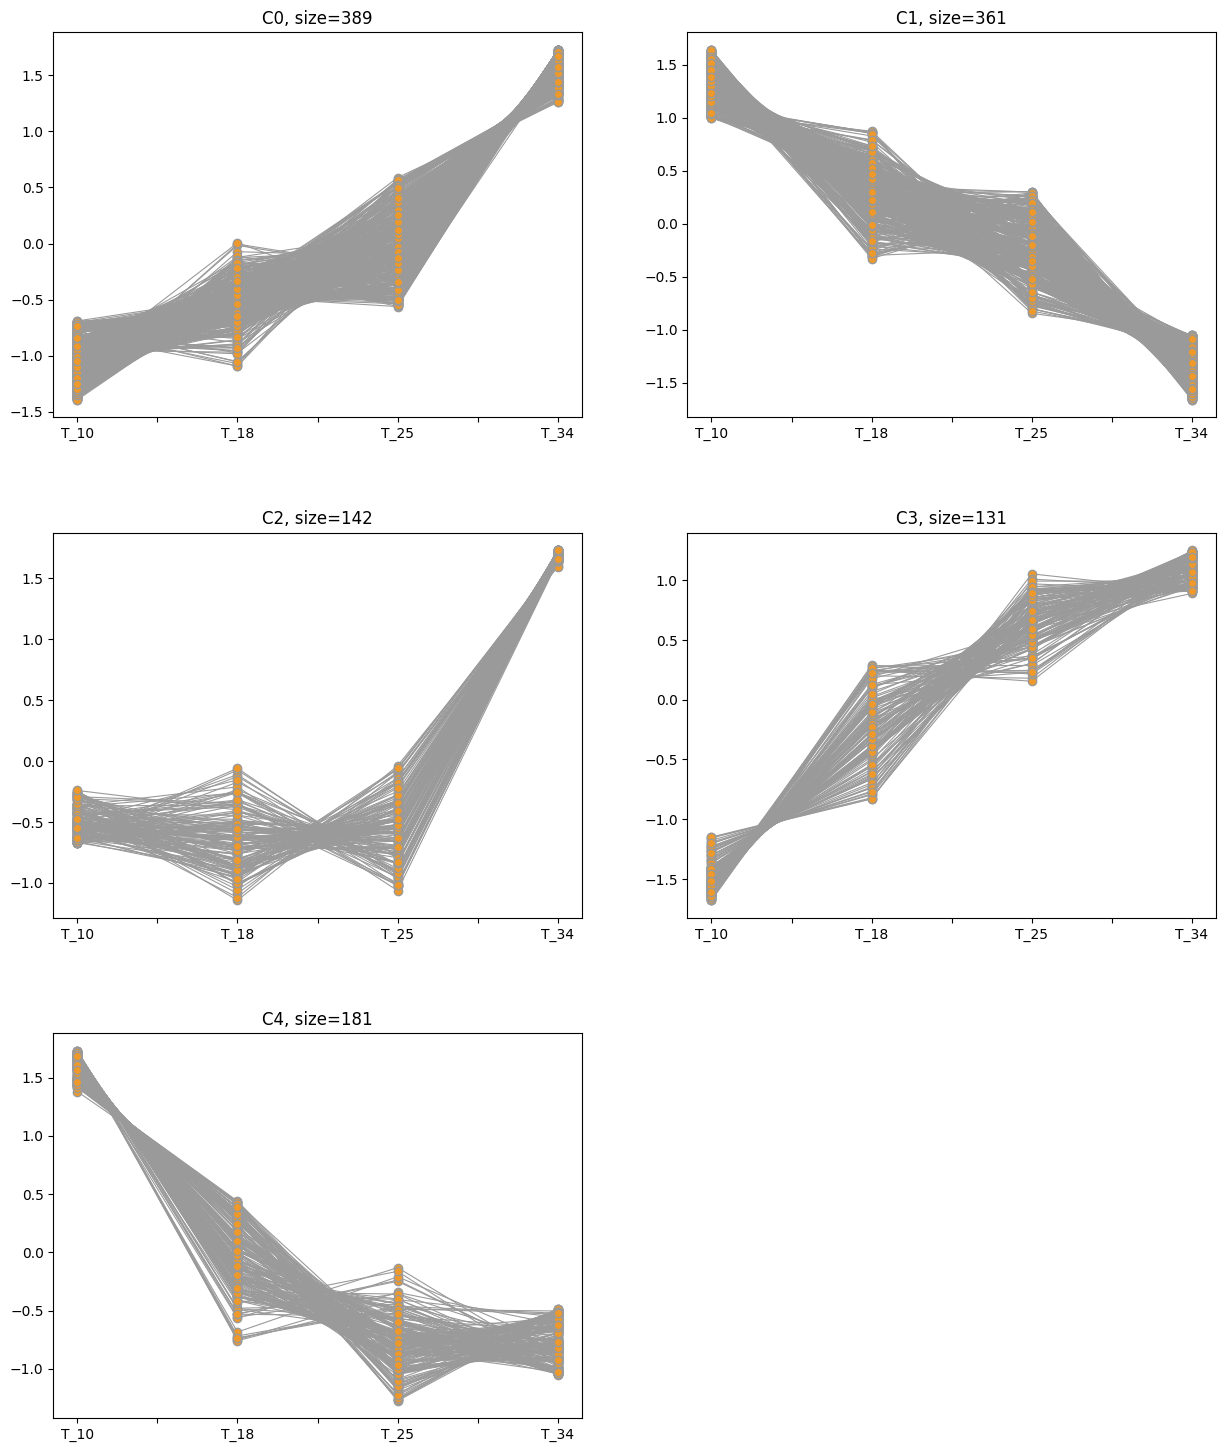

In [13]:
VI.plotClusters(plot_cluster_data_DS2Z, clusters_DS2Z)

## Find genes in clusters that are not DE according to the LRT test of Deseq2

There are about 790 DE genes across temperatures according to LRT, alpha=0.01, but over 1200 within the clusters. What happens with the genes that are not DE according to LRT but are in the clusters and do follow non random patterns?

In [14]:
print(f"There are {len(DE_genes_across_T)} genes that are differentially expressed across all temperatures.")

There are 1909 genes that are differentially expressed across all temperatures.


In [15]:
# DE_genes_across_T
clusters_DS2Z_noDE = {
    cluster_id: [g for g in cluster if g not in DE_genes_across_T]
    for cluster_id, cluster in clusters_DS2Z.items()
}

# Genes that are not DE across temperatures AND not included in any cluster
not_in_clusters_and_no_DE = [
    g for g in deseq2_counts_noDE.set_index("index").index
    if g not in DE_genes_across_T and g not in total_genes_in_clusters
]

print(f"There are {len(not_in_clusters_and_no_DE)} genes that are not DE across temperatures AND not included in any cluster.")

There are 886 genes that are not DE across temperatures AND not included in any cluster.


## Plot genes that are included in clusters but are not DE across temperatures

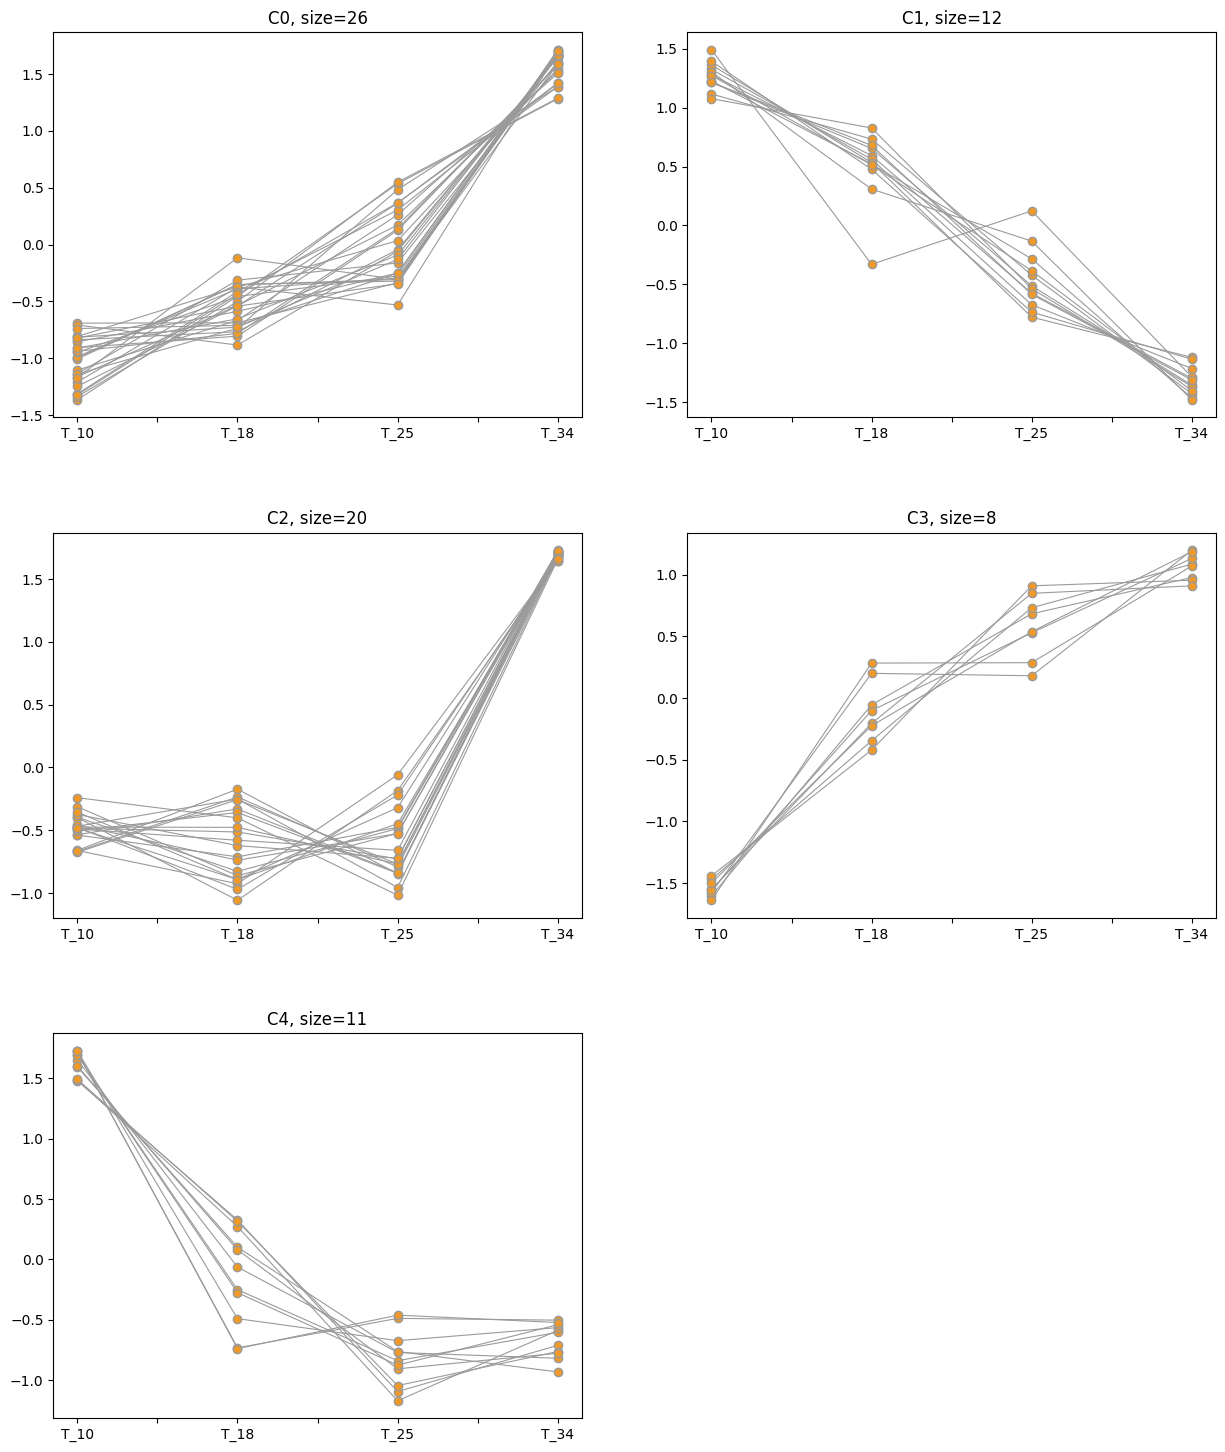

In [16]:
VI.plotClusters(plot_cluster_data_DS2Z, clusters_DS2Z_noDE)

## Annotate and rank genes within clusters

In [17]:
res_id = "CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2_ZSCORES"

cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Input_files_and_params/Data/clust_input.tsv'),
    sep='\t', index_col='index')
ranked_clusters_avg_expr = CA.rankGenesWithinClusters(clusters_DS2Z, cluster_data, method="median")

In [18]:
if not (results_dir / "pathways").exists():
   (results_dir / "pathways").mkdir(exist_ok=False)

no_kegg_pathway = []
ranked_clusters = []
for cluster_id in ranked_clusters_avg_expr:
    ranked_df = show_pathways_in_ranked_genes(
        ranked_clusters_avg_expr[cluster_id],
        gbk, gene_pathways,
        gene_systems, n=None
        )
    no_kegg_pathway.append( 100 * (ranked_df[((ranked_df.subsystem.str.contains("Unspecified")) & ~ ranked_df.subsystem.isna())].shape[0]) / ranked_df.shape[0] )
    ranked_df.insert(0, "cluster", cluster_id)
    ranked_df.to_csv(results_dir / "pathways" / f"ranked_{cluster_id}.csv")
    ranked_clusters.append(ranked_df)

merged_ranked_clusters = pd.concat(ranked_clusters).sort_values(by="value", ascending=False)
merged_ranked_clusters.to_csv(results_dir / "pathways" / "ranked_clusters.csv")
print(no_kegg_pathway)
print(np.mean(no_kegg_pathway))

[85.08997429305913, 63.43490304709141, 85.91549295774648, 84.73282442748092, 74.58563535911603]
78.7517660168988


## Ranked lists among the global 10% by expression

In [19]:
percent_cutoff = 10

filtered_ranked_clusters = {}

all_genes_expression = {gene: expr for cluster in ranked_clusters_avg_expr.values() for gene, expr in cluster.items()}

sorted_all_genes_expression = sorted(all_genes_expression.items(), key=lambda x:x[1], reverse=True)
sorted_all_genes_expression = dict(sorted_all_genes_expression)

cutoff_position = int( (10 / 100) * len(sorted_all_genes_expression) )
cutoff_value = list(sorted_all_genes_expression.values())[cutoff_position]
print(f"Cutoff average expression value of: {cutoff_value} Deseq2 values")
top_genes = list(sorted_all_genes_expression.keys())[:cutoff_position]

for cluster_id, cluster in ranked_clusters_avg_expr.items():
    filtered_ranked_clusters[cluster_id] = {gene: expr for gene, expr in cluster.items() if gene in top_genes}

Cutoff average expression value of: 12497.385577766818 Deseq2 values


In [20]:
# Cluster IDs in the top 10% of genes
top_10_ranked = merged_ranked_clusters.loc[merged_ranked_clusters.value > cutoff_value, :]
top_10_ranked.cluster.value_counts()

C1    80
C4    20
C0    11
C3     5
C2     4
Name: cluster, dtype: int64

Genes in the top 10% by expression (DeSeq2-normalized) tend to located in clusters with a downward pattern, negativaly correlated with temperature (clusters C1 and C4.)

## Rank temperature - independent genes and assign pathways

In [21]:
from dokdonia.utils import sort_dict_by_values

deseq2_avg = take_average_values(deseq2_counts.set_index("index"), method="median")

temp_indep_ranked_genes = {
    gene_id: deseq2_avg.loc[gene_id].median()
    for gene_id in not_in_clusters_and_no_DE
}

temp_indep_ranked_genes = sort_dict_by_values(temp_indep_ranked_genes, reverse=True)

# Add pathways
temp_indep_pathways = show_pathways_in_ranked_genes(
    temp_indep_ranked_genes, gbk, gene_pathways, gene_systems, n=None
    )

# Save to csv in pathways folder
temp_indep_pathways.to_csv(
    results_dir / "pathways" / "temp_indep_pathways.csv"
    )

temp_indep_pathways.head()

,product,subsystem,system,value
gene_id,,,,
MED134_12381,TonB dependent/ligand-gated channel,Unspecified,Unspecified,566480.218583
MED134_12376,hypothetical protein,Unspecified,Unspecified,304799.526157
MED134_10820,TonB dependent/ligand-gated channel,Unspecified,Unspecified,206480.203344
MED134_12371,hypothetical protein,Unspecified,Unspecified,205912.506617
MED134_02385,translation elongation factor Tu,Unspecified,Unspecified,142162.088862


In [22]:
temp_indep_pathways.loc[temp_indep_pathways.value > cutoff_value, "system"].value_counts()

Unspecified                                                                                                                                            38
[09102 Energy metabolism]                                                                                                                               5
[09122 Translation]                                                                                                                                     4
[09123 Folding, sorting and degradation, 09131 Membrane transport, 09145 Cellular community - prokaryotes]                                              2
[09101 Carbohydrate metabolism, 09101 Carbohydrate metabolism, 09101 Carbohydrate metabolism, 09108 Metabolism of cofactors and vitamins]               2
[09103 Lipid metabolism]                                                                                                                                2
[09132 Signal transduction]                                                 

## Find fraction of unannotated genes in clusters

As a side note, which fraciton of genes in Dokdonia MED134 are unannotated??

In [23]:
lines = ["gene_id\tgene_name\tproduct\tkegg_pathway\n"]
for gene_id in counts["index"]:   
    gene_info = gbk.getGeneInfo(gene_id)
    gene_name = gene_info["gene"][0] if "gene" in gene_info else "unspecified"
    product = gene_info["product"][0]
    kegg_pathway = ",".join(gene_pathways[gene_id]) if gene_id in gene_pathways else "unspecified"
    lines.append(
        (
            f"{gene_id}\t"
            f"{gene_name}\t"
            f"{product}\t"
            f"{kegg_pathway}\n"
            )
        )
with open(results_dir / "pathways" / "gene_annotations.tsv", "w") as file:
    file.writelines(lines)


annot = pd.read_csv(results_dir / "pathways" / "gene_annotations.tsv", sep="\t").set_index("gene_id")

print(f"Fraction of genes with no KEGG annotation: {sum(annot.kegg_pathway == 'unspecified') / len(annot):.2%}")
print(f"Fraction of genes with no product annotation: {sum(annot['product'] == 'hypothetical protein') / len(annot):.2%}")
print(f"Fraction of genes with no gene name annotation: {sum(annot['gene_name'] == 'unspecified') / len(annot):.2%}")

kegg_cluster_repr = []
for cluster_id, cluster_genes in clusters_DS2Z.items():
    kegg_cluster_repr.append(
        sum(annot.loc[cluster_genes].kegg_pathway == "unspecified") / len(cluster_genes)
    )
# Print average fraction of genes with no KEGG annotation per cluster
print(f"Average fraction of genes with no KEGG annotation per cluster: {np.mean(kegg_cluster_repr):.2%}")


Fraction of genes with no KEGG annotation: 74.66%
Fraction of genes with no product annotation: 37.96%
Fraction of genes with no gene name annotation: 74.21%
Average fraction of genes with no KEGG annotation per cluster: 78.75%


## Enriched metabolic pathways in Deseq2 clusters

In [24]:
from dokdonia.utils import terminal_execute

print(res_id)
out_dir = results_dir / "enrichment_results"
out_dir.mkdir(exist_ok=True)

clusters_path = results_dir / "clust" / f"{res_id}" / "Clusters_Objects.tsv"
stout = terminal_execute(
    command_str=(
    f"Rscript {root_dir / 'dokdonia' / 'clusterProfiler.R'}"
    f" {res_id} {clusters_path} {out_dir}"
    )
)

# Show enriched pathways
enrichment_results = pd.read_csv(out_dir / f"results_{res_id}.csv")

enrichment_results.Cluster = enrichment_results.Cluster.apply(lambda x: cluster_map[f"C{int(list(x)[-1]) - 1}"])
enrichment_results.set_index("Cluster", inplace=True)

# Write to csv file
enrichment_results.to_csv(out_dir / f"results_{res_id}.csv")
enrichment_results.head()

CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2_ZSCORES
Fatal error: cannot open file '/home/robaina/Documents/Aquifex/Dokdonia/dokdonia/clusterProfiler.R': No such file or directory


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
Cluster,,,,,,,,,
C0,dok03010,Ribosome - Dokdonia sp. MED134,38/134,38/281,2.458290e-14,1.155397e-12,1.155397e-12,MED134_00530/MED134_00535/MED134_00540/MED134_...,38
C1,dok00220,Arginine biosynthesis - Dokdonia sp. MED134,9/47,10/281,4.504452e-07,2.027003e-05,1.801781e-05,MED134_03484/MED134_03489/MED134_11911/MED134_...,9
C1,dok01230,Biosynthesis of amino acids - Dokdonia sp. MED134,14/47,34/281,2.413241e-04,5.429791e-03,4.826481e-03,MED134_03484/MED134_03489/MED134_04314/MED134_...,14
C1,dok01100,Metabolic pathways - Dokdonia sp. MED134,38/47,170/281,1.083556e-03,1.625333e-02,1.444741e-02,MED134_01325/MED134_01365/MED134_02085/MED134_...,38
C1,dok00250,"Alanine, aspartate and glutamate metabolism - ...",7/47,14/281,3.250142e-03,3.656409e-02,3.250142e-02,MED134_01325/MED134_03484/MED134_03489/MED134_...,7
